In [36]:
%reload_ext autoreload
%autoreload 2
from dataset.ieee_cis.data_manager import DataManager
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
dm = DataManager()
energy_data = dm.load_energy_data()

In [38]:
split_idx = len(energy_data['Solar0'][:dm.PHASE1_TIME]) - 1
start_time = energy_data['Solar0'].index[0]
end_time = energy_data['Solar0'].index[-1]
print(split_idx, start_time, end_time)

15208 2020-04-25 14:00:00 2020-11-30 23:45:00


In [39]:
### Load weather data
weather_data = dm.load_ERA5_weather_data()
weather_data = weather_data.drop(['coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
weather_data = weather_data.resample("15min").asfreq()
weather_data = weather_data.fillna(method='ffill')
# Take the Solar0 part
sss = weather_data[start_time:end_time].to_numpy()

In [40]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

day = 24*60*60
year = (365.2425)*day

# Transform timestamp into seconds
time_stamp = np.array(energy_data['Solar0'].index.map(pd.Timestamp.timestamp))
# Transform raw seconds into sin and cos value, creating a seasonal value that represent the repeat of day and year
day_sin = np.sin(time_stamp * (2 * np.pi/day))
day_cos = np.cos(time_stamp * (2 * np.pi/day))
year_sin = np.sin(time_stamp * (2 * np.pi/year))
year_cos = np.cos(time_stamp * (2 * np.pi/year))

# Stack all of the day and year
X_train = np.stack((day_sin, day_cos, year_sin, year_cos), axis=0).reshape((-1, 4))[:split_idx]
X_test = np.stack((day_sin, day_cos, year_sin, year_cos), axis=0).reshape((-1, 4))[split_idx:]

# Stack the day and year with weather data
X_train = np.hstack([X_train, sss[:split_idx]])
X_test = np.hstack([X_test, sss[split_idx:]])
y_train = energy_data['Solar0']['energy'][:split_idx].to_numpy()
y_true = energy_data['Solar0']['energy'][split_idx:].to_numpy()

In [41]:
print(X_train.shape, X_test.shape)
print(y_train.shape)

(15208, 12) (5856, 12)
(15208,)


In [42]:
model = linear_model.Lasso(alpha=0.9)
model.fit(X_train, y_train)

Lasso(alpha=0.9)

In [43]:
r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.6116696392720671
intercept: 11.085698644139299
slope: [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -3.11973376e-01  0.00000000e+00  0.00000000e+00 -1.08451527e-04
  0.00000000e+00  4.45426987e-02  9.88453896e-03 -0.00000000e+00]


In [44]:
y_pred = model.predict(X_test)
print(f"predicted response:\n{y_pred}")

predicted response:
[23.75319527 23.75319527 23.75319527 ...  6.86568784  6.86568784
  6.86568784]


58.734320693312014


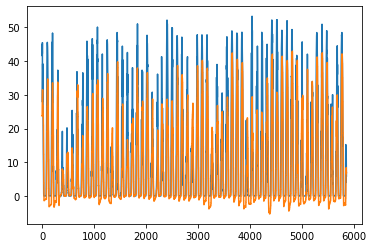

In [45]:
print(mean_squared_error(y_true, y_pred))
plt.plot(y_true)
plt.plot(y_pred)